# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from bs4 import BeautifulSoup

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [03:13<00:00, 1880.77it/s]


In [11]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [12]:
# creating other column for the cleaned data

final['cleaned_data']=preprocessed_reviews

In [13]:
# create samples for 8 sets

set1=final.sample(n=100000)   # BRUTE  BOW       100000 sample records
set2=final.sample(n=100000)   # BRUTE  TFIDF     100000 sample records
set3=final.sample(n=100000)   # BRUTE  AVGW2V    100000 sample records
set4=final.sample(n=100000)   # BRUTE  TFIDFW2V  100000 sample records
set5=final.sample(n=20000)    # KDTREE BOW        20000 sample records
set6=final.sample(n=20000)    # KDTREE TFIDF      20000 sample records
set7=final.sample(n=20000)    # KDTREE AVGW2V     20000 sample records
set8=final.sample(n=20000)    # KDTREE TFIDFW2V   20000 sample records

In [14]:
################## Train test split for BRUTE ##################

# dataset for BOW
set1_x,set1_x_test,set1_y,set1_y_test=train_test_split(set1['cleaned_data'],set1['Score'],test_size=0.3)

# dataset for TFIDF
set2_x,set2_x_test,set2_y,set2_y_test=train_test_split(set2['cleaned_data'],set2['Score'],test_size=0.3)

# dataset for AVGW2V
set3_x,set3_x_test,set3_y,set3_y_test=train_test_split(set3['cleaned_data'],set3['Score'],test_size=0.3)

# dataset for TFIDFW2V
set4_x,set4_x_test,set4_y,set4_y_test=train_test_split(set4['cleaned_data'],set4['Score'],test_size=0.3)


################## Train test split for KDTREE ##################


# dataset for BOW
set5_x,set5_x_test,set5_y,set5_y_test=train_test_split(set5['cleaned_data'],set5['Score'],test_size=0.3)

# dataset for TFIDF
set6_x,set6_x_test,set6_y,set6_y_test=train_test_split(set6['cleaned_data'],set6['Score'],test_size=0.3)

# dataset for AVGW2V
set7_x,set7_x_test,set7_y,set7_y_test=train_test_split(set7['cleaned_data'],set7['Score'],test_size=0.3)

# dataset for TFIDFW2V
set8_x,set8_x_test,set8_y,set8_y_test=train_test_split(set8['cleaned_data'],set8['Score'],test_size=0.3)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [15]:

###########################################################
# creating vectors from set1 using BOW for BRUTE          #
##########################################################

set1_count_vect=CountVectorizer(max_features=500,dtype='float64')
set1_x=set1_count_vect.fit_transform(set1_x)
set1_x_test=set1_count_vect.transform(set1_x_test)

# standarize the data
scaler=StandardScaler(with_mean=False)
set1_x=scaler.fit_transform(set1_x)
set1_x_test=scaler.transform(set1_x_test)


###########################################################
# creating vectors from set5 using BOW for KDTREE        #
##########################################################

set5_count_vect=CountVectorizer(max_features=500,dtype='float64')
set5_x=set5_count_vect.fit_transform(set5_x)
set5_x_test=set5_count_vect.transform(set5_x_test)

# convert sparse matrix into dense
set5_x=set5_x.toarray()
set5_x_test=set5_x_test.toarray()

# standarize the data
scaler=StandardScaler(with_mean=False)
set5_x=scaler.fit_transform(set5_x)
set5_x_test=scaler.transform(set5_x_test)


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [16]:

###########################################################
# creating vectors from set2 using TFIDF for BRUTE      #
##########################################################


set2_tfidf_vect=TfidfVectorizer(max_features=500,dtype='float64',ngram_range=(1,2))
set2_x=set2_tfidf_vect.fit_transform(set2_x)
set2_x_test=set2_tfidf_vect.transform(set2_x_test)

# standarize the data
scaler=StandardScaler(with_mean=False)
set2_x=scaler.fit_transform(set2_x)
set2_x_test=scaler.transform(set2_x_test)


###########################################################
# creating vectors from set6 using TFIDF for KDTREE      #
##########################################################

set6_tfidf_vect = TfidfVectorizer(max_features=500,ngram_range=(1,2),dtype='float64')
set6_x=set6_tfidf_vect.fit_transform(set6_x)
set6_x_test=set6_tfidf_vect.transform(set6_x_test)

# converting into dense vectors
set6_x=set6_x.toarray()
set6_x_test=set6_x_test.toarray()

# standarize the data
scaler=StandardScaler(with_mean=False)
set6_x=scaler.fit_transform(set6_x)
set6_x_test=scaler.transform(set6_x_test)



C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)


## [4.4] Word2Vec

In [17]:
# word2vec models 

set3_list_of_sentences=[]
for sentence in set3_x:
    set3_list_of_sentences.append(sentence.split())
    
set4_list_of_sentences=[]
for sentence in set4_x:
    set4_list_of_sentences.append(sentence.split())
    
set7_list_of_sentences=[]
for sentence in set7_x:
    set7_list_of_sentences.append(sentence.split())
    
set8_list_of_sentences=[]
for sentence in set8_x:
    set8_list_of_sentences.append(sentence.split())    

set3_w2v_model=Word2Vec(set3_list_of_sentences,min_count=5,size=500)   # BRUTE AVGW2V
set4_w2v_model=Word2Vec(set4_list_of_sentences,min_count=5,size=500)   # BRUTE TFIDFW2V
set7_w2v_model=Word2Vec(set7_list_of_sentences,min_count=5,size=500)   # KDTREE AVGW2V
set8_w2v_model=Word2Vec(set8_list_of_sentences,min_count=5,size=500)   # KDTREE TFIDFW2V


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [18]:
def AVGW2V(dataset,w2v_model):
    '''
    This function takes a data consisting of cleaned and preprocessed text reviews and word2vec training model 
    and converts them into vectors.
    Returns: 500 dimensional vectors.
    '''
    
    w2v_words=list(w2v_model.wv.vocab)    
    list_of_sentences=[]
    
    for sentence in dataset:
        list_of_sentences.append(sentence.split())
       
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentences): # for each review/sentence
        sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors


In [19]:

#######################################################
# creating vectors from set3 using AVGW2V for BRUTE   #
######################################################

set3_x=np.array(AVGW2V(set3_x,set3_w2v_model))
set3_x_test=np.array(AVGW2V(set3_x_test,set3_w2v_model))

scaler=StandardScaler(with_mean=False)
set3_x=scaler.fit_transform(set3_x)
set3_x_test=scaler.transform(set3_x_test)

###########################################################
# creating vectors from set7 using AVGW2V for KDTREE     #
##########################################################

set7_x=np.array(AVGW2V(set7_x,set7_w2v_model))
set7_x_test=np.array(AVGW2V(set7_x_test,set7_w2v_model))

# standarize the data
scaler=StandardScaler(with_mean=False)
set7_x=scaler.fit_transform(set7_x)
set7_x_test=scaler.transform(set7_x_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 439.98it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [20]:
def TFIDFW2V(dataset,w2v_model,tfidf_vect):    
    '''
    This function takes a dataset containing reviews, word2vec model and tfidf vectorizer model.
    Returns: 500 dimensional vectors. 
    '''
    
    list_of_sentences=[]
    tfidf_sent_vectors = []; 
    
    dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))
    tfidf_feat = tfidf_vect.get_feature_names()  
    w2v_words = list(w2v_model.wv.vocab)             
    
    for sentence in dataset:
        list_of_sentences.append(sentence.split())
    
    row=0;
    for sent in tqdm(list_of_sentences): # for each review/sentence 
        sent_vec = np.zeros(500) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#               tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)   # tf_idf should be only 50 dimensional because 
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    # top 500 features 
    return tfidf_sent_vectors


In [21]:

###########################################################
# creating vectors from set4 using TFIDFW2V for BRUTE     #
##########################################################

set4_tfidf_vect = TfidfVectorizer(max_features=500,ngram_range=(1,2),dtype='float64')
set4_tfidf_vect.fit(set4_x)   

set4_x=TFIDFW2V(set4_x,set4_w2v_model,set4_tfidf_vect)
set4_x_test=TFIDFW2V(set4_x_test,set4_w2v_model,set4_tfidf_vect)

# standarize the data
scaler=StandardScaler(with_mean=False)
set4_x=scaler.fit_transform(set4_x)
set4_x_test=scaler.transform(set4_x_test)


##########################################################
# creating vectors from set8 using TFIDFW2V for KDTREE   #
##########################################################

set8_tfidf_vect = TfidfVectorizer(max_features=500,ngram_range=(1,2),dtype='float64')
set8_tfidf_vect.fit(set8_x)   

set8_x=TFIDFW2V(set8_x,set8_w2v_model,set8_tfidf_vect)
set8_x_test=TFIDFW2V(set8_x_test,set8_w2v_model,set8_tfidf_vect)

# standarize the data
scaler=StandardScaler(with_mean=False)
set8_x=scaler.fit_transform(set8_x)
set8_x_test=scaler.transform(set8_x_test)

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:36<00:00, 312.36it/s]
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 436.78it/s]


<h1>Important functions</h1>

In [22]:
   
def plot_auc_vs_hyperpameter(param_grid,grid):
    '''
    This function plots the variation of auc of roc for train and cv data using Grid Search.
    Returns : optimal number of neighbours
    '''
    plt.close()
    plt.plot(param_grid['n_neighbors'],grid.cv_results_['mean_test_score'],label='Validation AUC')
    plt.plot(param_grid['n_neighbors'],grid.cv_results_['mean_train_score'],label='Train AUC')
    
    plt.xlabel('Hyper parameter')
    plt.ylabel('Area under ROC Curve')
    plt.title('Area under ROC curve V/S Hyper Parameter for CV and train datasets')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    
    optimal_k=grid.best_params_['n_neighbors']        
    
    return optimal_k


def plot_roc_curve(train_x,train_y,test_x,test_y,estimator):
    '''
    This curve takes train and test datasets, estimator to plot roc curves for train 
    and test datasets. Please initialize the estimator with necessary parameters before calling this function.
    Returns: a dictionary "auc_and_Ypred" containing test data auc and predicted test scores.
    '''
    plt.close()
    estimator.fit(train_x,train_y)
    
    test_y_pred_prob_score=estimator.predict_proba(test_x)[:,1]
    fpr_test,tpr_test,thresholds_test=roc_curve(test_y,test_y_pred_prob_score)
    
    test_y_pred=threshold_based_predict(test_y_pred_prob_score,fpr_test,tpr_test,thresholds_test)
    
    plt.plot(fpr_test,tpr_test,'r',label='TEST')
    
    train_y_pred_prob_score=estimator.predict_proba(train_x)[:,1]
    fpr_train,tpr_train,thresholds_train=roc_curve(train_y,train_y_pred_prob_score)
    plt.plot(fpr_train,tpr_train,'b',label='TRAIN')
    
    # print auc for roc for test
    print('ROC AUC for test data',roc_auc_score(test_y,test_y_pred_prob_score)) 
    
   
    # plot roc curve
    plt.plot([0,1],[0,1],'k')
    
    plt.title('ROC for TRAIN and TEST data')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.legend()
    plt.show() 
    
    best_auc=roc_auc_score(test_y,test_y_pred_prob_score)
    auc_and_Ypred={}
    auc_and_Ypred['best_auc']=best_auc
    auc_and_Ypred['y_pred']=test_y_pred
      
    return auc_and_Ypred
    
    

def threshold_based_predict(probability_scores,fpr,tpr,thresholds):
    '''
    This function takes probability scores, fpr, tpr and thresholds. We need this function to handle the under-fitting.
    Without this function the model tries to predict all the points as majority class. It uses tpr and fpr to decide 
    the cutoff point below which everything will be predicted as 0 and above which everything is predicted as 1.
        
    Reference: https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    
    As mentioned in the website, there are few suggestions for choosing cutoff points. I have used third as cut-off point. Results with 3rd looks fine.     
      
    cutoff=thresholds[np.argmax(fpr*(1-tpr))]                                         (1)
    cutoff=thresholds[np.argmax(tpr-fpr)]                                             (2)
    cutoff=thresholds[np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))]          (3)
    
    Returns: Predicted scores
    '''
    
    predictions=[]
    
#     cutoff=thresholds[np.argmax(fpr*(1-tpr))]
    
#     cutoff=thresholds[np.argmax(tpr-fpr)]   # better
    
    cutoff=thresholds[np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))] 

    for p in probability_scores:
        if p>=cutoff:
            predictions.append(1)
        else:
            predictions.append(0)
    print('optimal theshold',cutoff)
    return predictions   
    
    
def plot_confusion_matrix(test_y,test_y_pred):
    '''
    This function takes test class labels and predicted class labels and plots confusion matrix.
    '''

    cm=confusion_matrix(test_y,test_y_pred)
    
    label=pd.DataFrame(cm)
    label.iloc[0,0]='TN={}'.format(label.iloc[0,0])
    label.iloc[0,1]='FN={}'.format(label.iloc[0,1])
    label.iloc[1,0]='FP={}'.format(label.iloc[1,0])
    label.iloc[1,1]='TP={}'.format(label.iloc[1,1])
    
    plt.close()
    plt.figure(figsize=(6,4))   

    sns.heatmap(cm,xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'],
                cmap='Dark2',annot=label,linewidths=1,linecolor='black',fmt='s')
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix for Test data')
    plt.show()  

<h1>setting up vars and initiaizing the classifiers.</h1>

In [23]:
#setting up vars and initiaizing the classifiers.

# range of neighbors
param_grid={'n_neighbors':[x for x in range(1,30)]}         

# knn brute force model
knn_brute=KNeighborsClassifier(algorithm='brute')

# knn brute force model
knn_kdTree=KNeighborsClassifier(algorithm='kd_tree')

# gridcv brute force model
grid_brute=GridSearchCV(knn_brute,param_grid,scoring='roc_auc')

# gridcv kd tree model
grid_kdTree=GridSearchCV(knn_kdTree,param_grid,scoring='roc_auc')

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

----------------------BRUTE BOW--------------------------


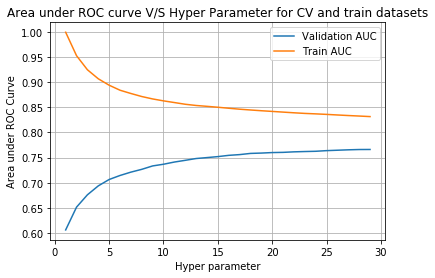

optimal theshold 0.8275862068965517
ROC AUC for test data 0.7765992229404426


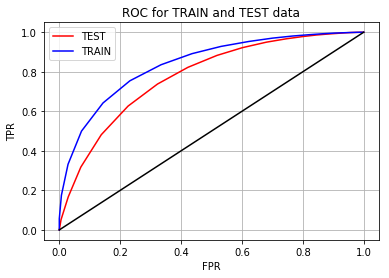

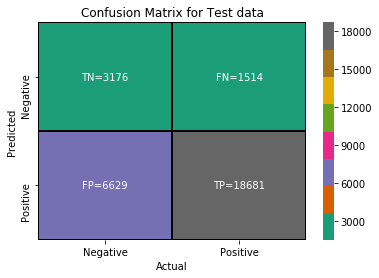

set1_optimal_k: 29 set1_best_auc: 0.7765992229404426


In [24]:
# Please write all the code with proper documentation

##############
# BRUTE BOW #
##############

print('----------------------BRUTE BOW--------------------------')

# train the grid and find optimal number of neighbors
grid_brute.fit(set1_x,set1_y)    
set1_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_brute)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='brute',n_neighbors=set1_optimal_k)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,set1_y,set1_x_test,set1_y_test,clf)

# plot confusion matrix
plot_confusion_matrix(set1_y_test,set1_auc_and_Ypred['y_pred'])

# Store the set1 results
print('set1_optimal_k:',set1_optimal_k,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW','Brute',set1_optimal_k,set1_auc_and_Ypred['best_auc']]


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

---------------BRUTE TFIDF-------------------


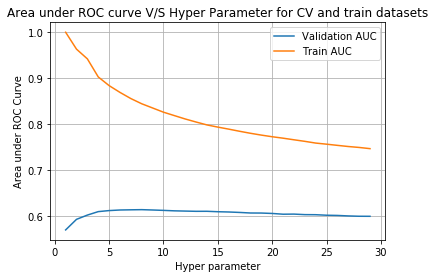

optimal theshold 0.875
ROC AUC for test data 0.6360861354438546


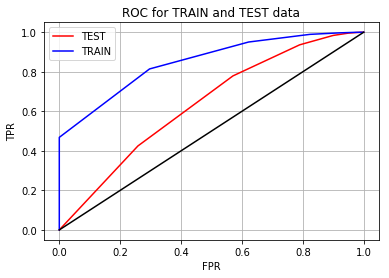

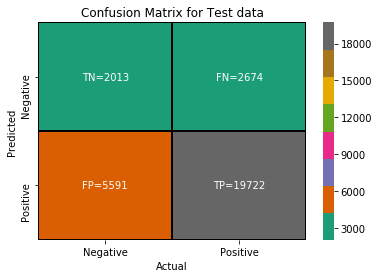

set2_optimal_k: 8 set2_best_auc: 0.6360861354438546


In [25]:
# Please write all the code with proper documentation

##############
# BRUTE TFIDF#
##############

print('---------------BRUTE TFIDF-------------------')

# train the grid and find optimal number of neighbors
grid_brute.fit(set2_x,set2_y)
set2_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_brute)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='brute',n_neighbors=set2_optimal_k)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,set2_y,set2_x_test,set2_y_test,clf)

# Plot confusion matrix

plot_confusion_matrix(set2_y_test,set2_auc_and_Ypred['y_pred'])

# store the set2 results
print('set2_optimal_k:',set2_optimal_k,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF','Brute',set2_optimal_k,set2_auc_and_Ypred['best_auc']]

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

------------------BRUTE AVGW2V--------------


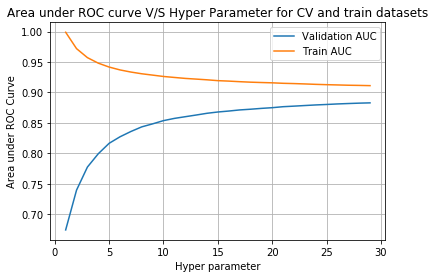

optimal theshold 0.8275862068965517
ROC AUC for test data 0.8862792758502579


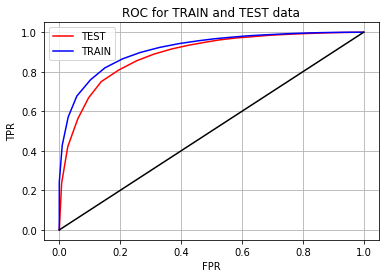

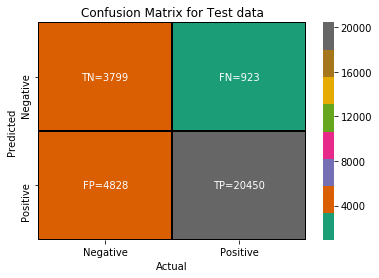

set3_optimal_k: 29 set3_best_auc: 0.8862792758502579


In [26]:
# Please write all the code with proper documentation


###############
# BRUTE AVGW2V#
###############

print('------------------BRUTE AVGW2V--------------')

# train the grid and find optimal number of neighbors
grid_brute.fit(set3_x,set3_y)
set3_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_brute)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='brute',n_neighbors=set3_optimal_k)

# find the test dataset roc auc and predicted class labels
set3_auc_and_Ypred=plot_roc_curve(set3_x,set3_y,set3_x_test,set3_y_test,clf)

# Plot confusion matrix
plot_confusion_matrix(set3_y_test,set3_auc_and_Ypred['y_pred'])

# store the set3 results
print('set3_optimal_k:',set3_optimal_k,'set3_best_auc:',set3_auc_and_Ypred['best_auc'])
set3_result=['AVGW2V','Brute',set3_optimal_k,set3_auc_and_Ypred['best_auc']]


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

-------------BRUTE TFIDFW2V-------------------


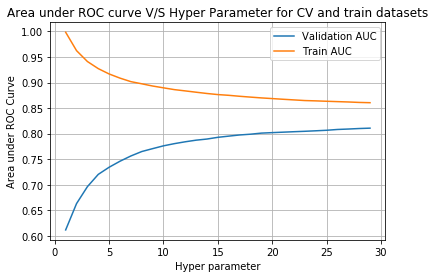

optimal theshold 0.8620689655172413
ROC AUC for test data 0.8184728542762565


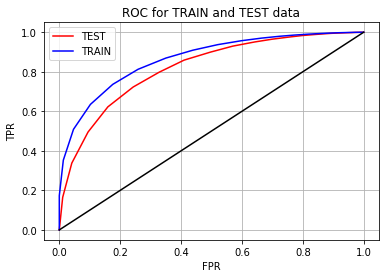

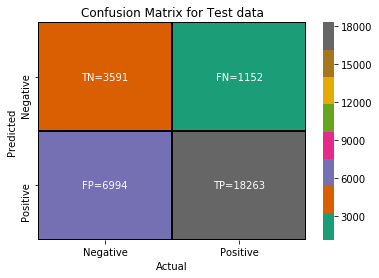

set4_optimal_k: 29 set4_best_auc: 0.8184728542762565


In [27]:
# Please write all the code with proper documentation


#################
# BRUTE TFIDFW2V#
#################

print('-------------BRUTE TFIDFW2V-------------------')

# train the grid and find optimal number of neighbors
grid_brute.fit(set4_x,set4_y)
set4_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_brute)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='brute',n_neighbors=set4_optimal_k)

# find the test dataset roc auc and predicted class labels
set4_auc_and_Ypred=plot_roc_curve(set4_x,set4_y,set4_x_test,set4_y_test,clf)

# Plot confusion matrix
plot_confusion_matrix(set4_y_test,set4_auc_and_Ypred['y_pred'])

# store the set4 results
print('set4_optimal_k:',set4_optimal_k,'set4_best_auc:',set4_auc_and_Ypred['best_auc'])
set4_result=['TFIDFW2V','Brute',set4_optimal_k,set4_auc_and_Ypred['best_auc']]




## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

-------------KDTREE BOW------------


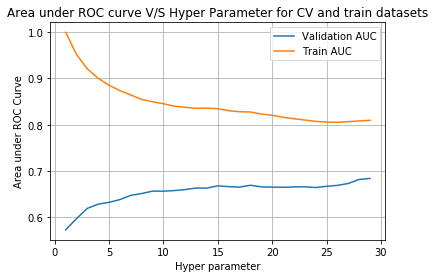

optimal theshold 0.896551724137931
ROC AUC for test data 0.7087571739926808


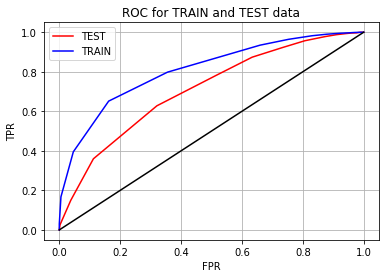

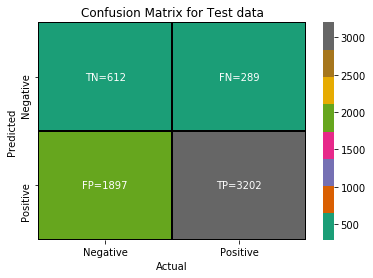

set5_optimal_k: 29 set5_best_auc: 0.7087571739926808


In [28]:
# Please write all the code with proper documentation


##############
# KDTREE BOW #
##############

print('-------------KDTREE BOW------------')

# train the grid and find optimal number of neighbors
grid_kdTree.fit(set5_x,set5_y)
set5_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_kdTree)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=set5_optimal_k)

# find the test dataset roc auc and predicted class labels
set5_auc_and_Ypred=plot_roc_curve(set5_x,set5_y,set5_x_test,set5_y_test,clf)

# Plot confusion matrix
plot_confusion_matrix(set5_y_test,set5_auc_and_Ypred['y_pred'])

# store the set5 results
print('set5_optimal_k:',set5_optimal_k,'set5_best_auc:',set5_auc_and_Ypred['best_auc'])
set5_result=['BOW','kd_tree',set5_optimal_k,set5_auc_and_Ypred['best_auc']]


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

------------------KDTREE TFIDF---------------


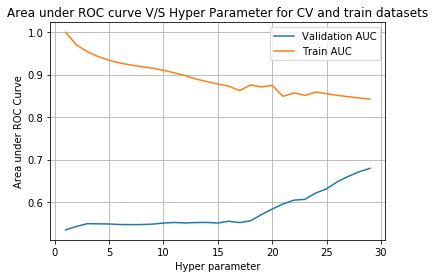

optimal theshold 0.9655172413793104
ROC AUC for test data 0.5785861907751719


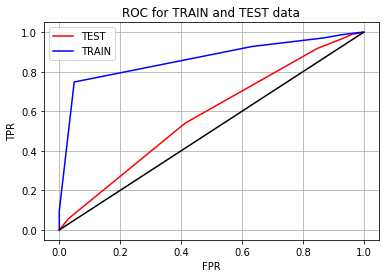

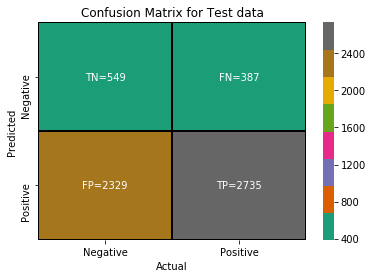

set6_optimal_k: 29 set6_best_auc: 0.5785861907751719


In [31]:
# Please write all the code with proper documentation

##############
#KDTREE TFIDF#
##############

print('------------------KDTREE TFIDF---------------')

# train the grid and find optimal number of neighbors
grid_kdTree.fit(set6_x,set6_y)
set6_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_kdTree)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=set6_optimal_k)

# find the test dataset roc auc and predicted class labels
set6_auc_and_Ypred=plot_roc_curve(set6_x,set6_y,set6_x_test,set6_y_test,clf)

# Plot confusion matrix
plot_confusion_matrix(set6_y_test,set6_auc_and_Ypred['y_pred'])

# store the set6 results
print('set6_optimal_k:',set6_optimal_k,'set6_best_auc:',set6_auc_and_Ypred['best_auc'])
set6_result=['TFIDF','kd_tree',set6_optimal_k,set6_auc_and_Ypred['best_auc']]


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>  
<b>Note:</b> I have used set7 instead of set3 to maintain a proper nomenclature

-------------------KDTREE AVGW2V-----------------


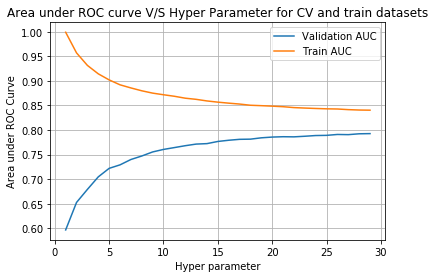

optimal theshold 0.8275862068965517
ROC AUC for test data 0.8114180320594078


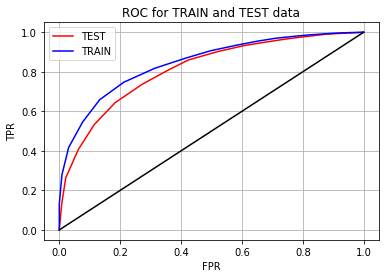

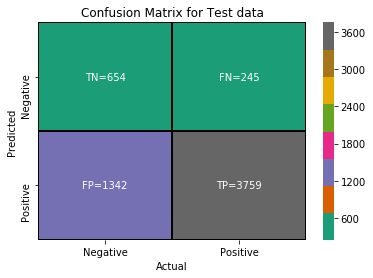

set7_optimal_k: 29 set7_best_auc: 0.8114180320594078


In [32]:
# Please write all the code with proper documentation


#################
# KDTREE AVGW2V #
#################

print('-------------------KDTREE AVGW2V-----------------')

# train the grid and find optimal number of neighbors
grid_kdTree.fit(set7_x,set7_y)
set7_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_kdTree)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=set7_optimal_k)

# find the test dataset roc auc and predicted class labels
set7_auc_and_Ypred=plot_roc_curve(set7_x,set7_y,set7_x_test,set7_y_test,clf)

# Plot confusion matrix
plot_confusion_matrix(set7_y_test,set7_auc_and_Ypred['y_pred'])

# store the set7 results
print('set7_optimal_k:',set7_optimal_k,'set7_best_auc:',set7_auc_and_Ypred['best_auc'])
set7_result=['AVGW2V','kd_tree',set7_optimal_k,set7_auc_and_Ypred['best_auc']]


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

<b>Note:</b> I have used set8 instead of set4 to maintain a proper nomenclature

---------------------KDTREE TFIDFW2V---------------------


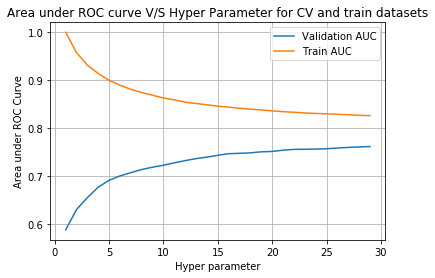

optimal theshold 0.8620689655172413
ROC AUC for test data 0.7774609141648491


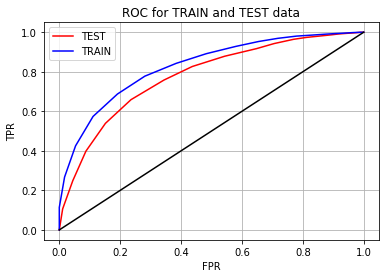

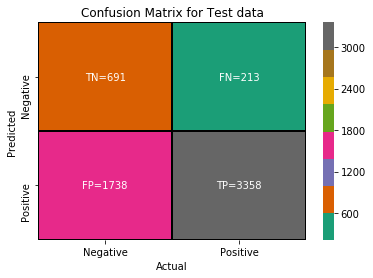

set8_optimal_k: 29 set8_best_auc: 0.7774609141648491


In [33]:
# Please write all the code with proper documentation


###################
# KDTREE TFIDFW2V #
###################

print('---------------------KDTREE TFIDFW2V---------------------')

# train the grid and find optimal number of neighbors
grid_kdTree.fit(set8_x,set8_y)
set8_optimal_k=plot_auc_vs_hyperpameter(param_grid,grid_kdTree)

# train knn with optimal number of neighbors
clf=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=set8_optimal_k)

# find the test dataset roc auc and predicted class labels
set8_auc_and_Ypred=plot_roc_curve(set8_x,set8_y,set8_x_test,set8_y_test,clf)

# Plot confusion matrix
plot_confusion_matrix(set8_y_test,set8_auc_and_Ypred['y_pred'])

# store the set8 results
print('set8_optimal_k:',set8_optimal_k,'set8_best_auc:',set8_auc_and_Ypred['best_auc'])
set8_result=['TFIDFW2V','kd_tree',set8_optimal_k,set8_auc_and_Ypred['best_auc']]


# [6] Conclusions

In [34]:
# Please compare all your models using Prettytable library


table=PrettyTable(field_names=['Vectorizer','Model','HyperParameter','AUC'])

#We will use set5, set6, set7 and set8 for Brute force implementations for BOW, TFIDF, AVGW2V and TFIDFW2V respectively.

table.add_row(set1_result)
table.add_row(set2_result)
table.add_row(set3_result)
table.add_row(set4_result)

#We will use set5, set6, set7 and set8 for KD Tree implementations for BOW, TFIDF, AVGW2V and TFIDFW2V respectively.

table.add_row(set5_result)
table.add_row(set6_result)
table.add_row(set7_result)
table.add_row(set8_result)

# print the table
print(table)



+------------+---------+----------------+--------------------+
| Vectorizer |  Model  | HyperParameter |        AUC         |
+------------+---------+----------------+--------------------+
|    BOW     |  Brute  |       29       | 0.7765992229404426 |
|   TFIDF    |  Brute  |       8        | 0.6360861354438546 |
|   AVGW2V   |  Brute  |       29       | 0.8862792758502579 |
|  TFIDFW2V  |  Brute  |       29       | 0.8184728542762565 |
|    BOW     | kd_tree |       29       | 0.7087571739926808 |
|   TFIDF    | kd_tree |       29       | 0.5785861907751719 |
|   AVGW2V   | kd_tree |       29       | 0.8114180320594078 |
|  TFIDFW2V  | kd_tree |       29       | 0.7774609141648491 |
+------------+---------+----------------+--------------------+
